# Reconstruction using OpenCV

Your name: Dylan Rodrigues

Your ID number: 24121479

No we're going to read two images in, a left image and a right image. And we are going to estimate the essential matrix between the two images.

In the last e-tivity, you estimated the homography that let us transform the images, at least approximately, so that we could line them up in a panorama. But it was a 2D estimation that works for planar scenes. The essential matrix, in a way, allows us to extend this concept beyond the need for a 2D scene, we can accept a 3D scene.

## Read the images, calibration, and do the feature extraction

Let's start by reading the two images.

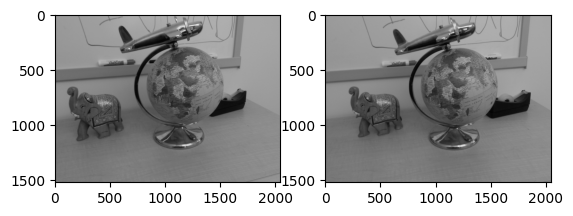

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

imgL_color = cv2.imread('globe1.jpg')
imgR_color = cv2.imread('globe2.jpg')

imgL_color = cv2.cvtColor(imgL_color, cv2.COLOR_BGR2RGB)
imgR_color = cv2.cvtColor(imgR_color, cv2.COLOR_BGR2RGB)

imgL = cv2.imread('globe1.jpg',cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('globe2.jpg',cv2.IMREAD_GRAYSCALE)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(imgL,cmap='gray')
axarr[1].imshow(imgR,cmap='gray');

We need the calibration to generate the essential matrix. We looked before at how to calibrate a camera, so we won't go through that again. Here, we just use the calibration.

In [2]:
# The calibration is the same for both images, as they were captured using the same camera.

# First two are radial distortion, second two are tangential, which we ignore (set to zero)
dist = np.array([0.138220594989358, -0.291158084324502, 0, 0])

# The projection matrix.
K_init = np.array([[1901.61685419446, 0               , 1051.33708372959],
                   [0               , 1894.94457228005, 778.616424720309],
                   [0               , 0               , 1               ]])

h, w = imgL.shape[:2]


It's not obvious form the images above, but there is a slight radial distortion. We want to work with undistorted images (it makes our life a little easier). So, here, we undistort before the feature extraction.

In [3]:
# We're going to use OpenCV to do this.
# When you undistort, we change the camera matrix slightly. OpenCV provides a hady function that updates this.
K_new, roi = cv2.getOptimalNewCameraMatrix(K_init, dist, (w,h), 1, (w,h))

# Now we will undistort the image pair
imgL = cv2.undistort(imgL, K_init, dist, None, K_new)
imgR = cv2.undistort(imgR, K_init, dist, None, K_new)

# we will just store the new camera matrix
K = K_new

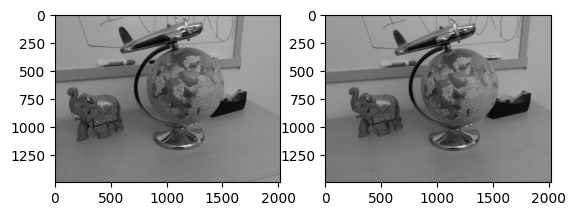

In [4]:
# crop the image.
# Usefully, getOptimalNewCameraMatrix returns an roi that defines the area of the image without the black bits.
# Crop using np.array slicing
%matplotlib inline

x, y, w, h = roi
imgL = imgL[y:y+h, x:x+w]
imgR = imgR[y:y+h, x:x+w]

# plot
f, axarr = plt.subplots(1,2)
axarr[0].imshow(imgL,cmap='gray')
axarr[1].imshow(imgR,cmap='gray');

In previous vision modules, you will have covered feature matching. I don't expect you to repeat that here. So I will give you the code to match the two images using ORB. And we will match the features between the frames.

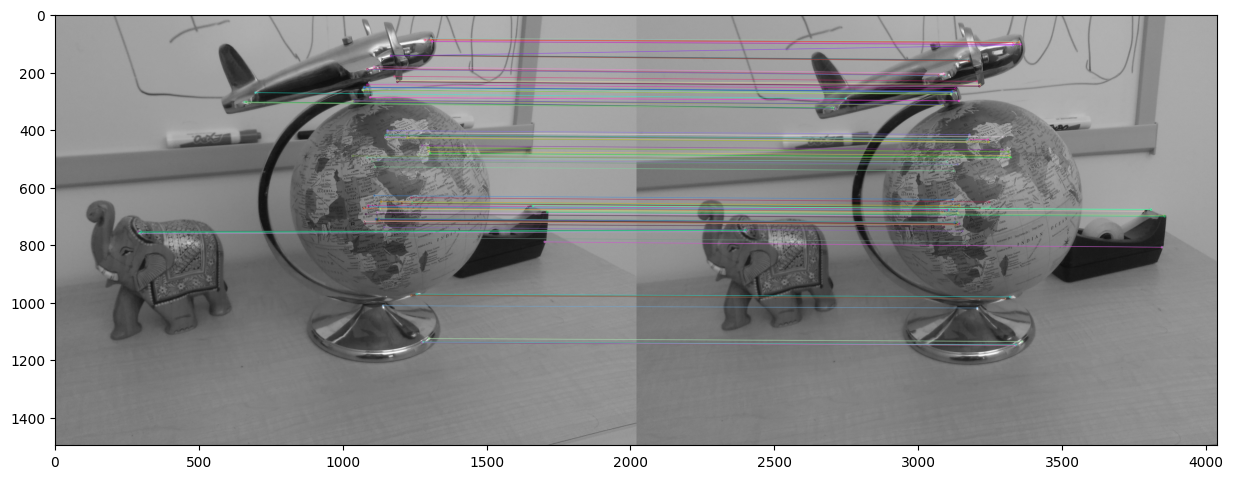

In [5]:
%matplotlib inline

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(imgL,None)
kp2, des2 = orb.detectAndCompute(imgR,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

N_PTS = 150

img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:N_PTS],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:N_PTS]]).reshape(-1,2)
rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:N_PTS]]).reshape(-1,2)

## Estimate the Essential Matrix using OpenCV


We saw that the previous DLT method for finding the essential matrix was not the most robust, so we like to use a more robust method. RANSAC is the answer, but we won't implement it ourselves. We'll use OpenCV.

Look at the OpenCV documentation for [`cv2.findEssentialMatrix`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga0b166d41926a7793ab1c351dbaa9ffd4). Which is the appropriate version (hint, we have two sets of points and a camera matrix). Note that the OpenCV function can handle pixel points, as it will convert it internally to normalised points.

<font color='blue'>
    
**Task**: estimate the essential matrix using OpenCV.

In [6]:
# Estimate the essential matrix using RANSAC
E, mask = cv2.findEssentialMat(left_pts, rght_pts, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# Print the essential matrix
print("Essential Matrix:\n", E)

Essential Matrix:
 [[ 0.00841849  0.13606081 -0.06657805]
 [-0.07075375 -0.00151496 -0.70041986]
 [ 0.07703265  0.68952173  0.00365261]]


In [7]:
np.linalg.matrix_rank(E)

3

In [8]:
def enforce_rank2_constraint(E):
    """
    Enforce the rank-2 constraint on the essential matrix.
    """
    U, S, Vt = np.linalg.svd(E, full_matrices=True)
    print(S)
    S[-1] = 0  # Set the smallest singular value to zero
    E_rank2 = U @ np.diag(S) @ Vt  # Recompute E with enforced rank-2 constraint
    return E_rank2

# Enforce the rank-2 constraint
E_rank2 = enforce_rank2_constraint(E)
print("Rank of Essential Matrix after enforcing rank-2 constraint:", np.linalg.matrix_rank(E_rank2))

print("Estimated Essential Matrix:")
print(E_rank2)

[7.07106781e-01 7.07106781e-01 1.94153488e-11]
Rank of Essential Matrix after enforcing rank-2 constraint: 2
Estimated Essential Matrix:
[[ 0.00841849  0.13606081 -0.06657805]
 [-0.07075375 -0.00151496 -0.70041986]
 [ 0.07703265  0.68952173  0.00365261]]


Now let's draw the epipolar lines





<font color='blue'>
    
**Task:** Pick a handful of the features, draw the features (in both images), and draw the corresponding epipolar lines in the right hand image. Plot the resulting image pair.
    
Notes:
* This is basically the same as the last assignment.

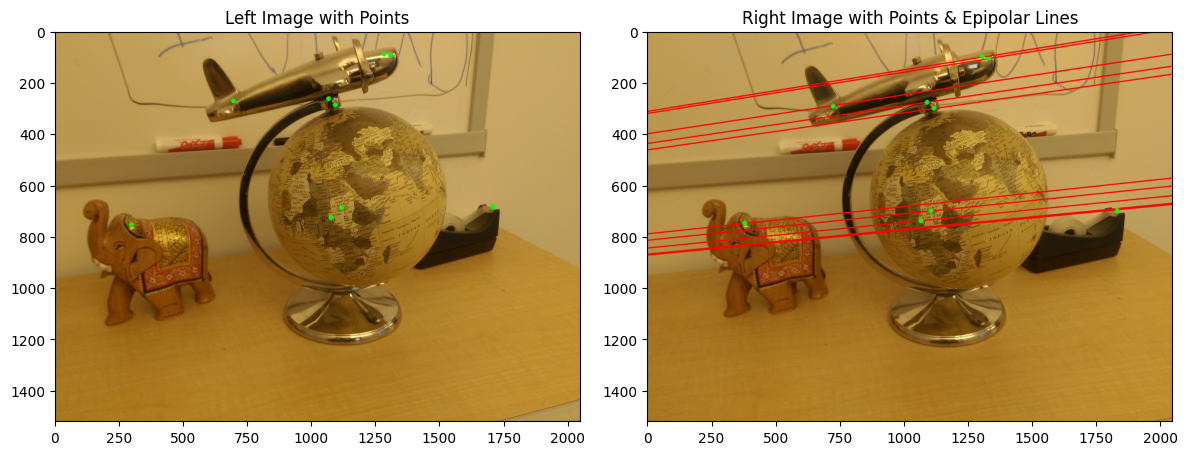

In [12]:
def display_epipolar_lines(left_img, right_img, left_points, right_points, E, K):

  # For simplicity just take 10 pts
  num_points = 10

  for i in range(num_points):
    # Destructure left and right points
    current_left_point, current_right_point = left_points[i], right_points[i]

    # Homogenize
    current_left_point_homogenous = np.array([current_left_point[0], current_left_point[1], 1.0])

    # Normalize
    current_left_point_normailized = np.linalg.inv(K) @ current_left_point_homogenous

    # To get the epipolar line in the right normalised image, multiply the left ideal/normalised point by the essential matrix l′=Ex
    l_n = E.dot(current_left_point_normailized)

    # To get the line in pixel coordinates, do l′img=K−⊤l′
    l_img = np.linalg.inv(K).T.dot(l_n)

    a, b, c = l_img[0], l_img[1], l_img[2]

    # Right image width and height
    h, w = right_img.shape[:2]

    # Get line coordinates
    if (b != 0):
      [x0, y0] = [int(-c / a) if (a != 0) else 0, 0]
      [x1, y1] = [int(-(c + b*(h-1)) / a) if (a != 0) else w-1, h-1]
    else:
      x0 = x1 = int(-c / a)
      y0 = 0
      y1 = h-1

    # Use the opencv function cv2.line to draw the epipolar line
    cv2.line(right_img, (x0, y0), (x1, y1), (255, 0, 0), 4)
    cv2.circle(left_img,  (int(current_left_point[0]), int(current_left_point[1])), 5, (0, 255, 0), 8)
    cv2.circle(right_img, (int(current_right_point[0]), int(current_right_point[1])), 5, (0, 255, 0), 8)

  # Plot
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(left_img)
  plt.title("Left Image with Points")

  plt.subplot(1, 2, 2)
  plt.imshow(right_img)
  plt.title("Right Image with Points & Epipolar Lines")

  plt.tight_layout()
  plt.show()


# Draw epipolar lines
display_epipolar_lines(imgL_color, imgR_color, left_pts, rght_pts, E_rank2, K)

## Decompose the essential matrix

Remember that the essential matrix is made up from a rotation matrix $\mathbf{R}$ and a translation vector $\mathbf{t}$, i.e., $\mathbf{E} = \left[\mathbf{t}\right]_\times \mathbf{R}$. Often we will want to deconstruct the essential matrix into its constituent parts $\mathbf{E} \rightarrow \mathbf{R}, \mathbf{t}$.

However, there is a theoretical ambiguity when reconstructing the relative poses of two cameras from the essential matrix. This ambiguity is linked to the fact that, given a 2D point in an image, the pinhole camera model cannot tell whether the corresponding 3D point is in front of the camera or behind the camera. Fundamentally, for a given essential matrix, we cannot distinguish the following scenarios.

![image.png](attachment:image.png)

In order to remove this ambiguity, you need to know at least one point correspondence in the images: as these two 2D points are assumed to be the projections of a single 3D point lying in front of both cameras (since it is visible in both images), this will enable choosing the right $\mathbf{R}$ and $\mathbf{t}$. The details for this are [provided here](https://stackoverflow.com/questions/22807039/decomposition-of-essential-matrix-validation-of-the-four-possible-solutions-for).

Luckily, OpenCV provides a function for this - [`cv2.recoverPose`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gadb7d2dfcc184c1d2f496d8639f4371c0)

<font color='blue'>
    
**Task**: Decompose the essential matrix, and select the correct rotation and translation, using OpenCV

In [19]:
import cv2
import numpy as np

def decompose_essential_matrix(E, left_pts, right_pts, K):
    # Convert points to homogeneous coordinates
    left_pts_homogeneous = np.hstack((left_pts, np.ones((left_pts.shape[0], 1))))
    right_pts_homogeneous = np.hstack((right_pts, np.ones((right_pts.shape[0], 1))))

    # Normalize points using the camera matrix
    left_pts_normalized = (np.linalg.inv(K) @ left_pts_homogeneous.T).T
    right_pts_normalized = (np.linalg.inv(K) @ right_pts_homogeneous.T).T

    # Recover pose from the Essential Matrix
    _, R, t, _ = cv2.recoverPose(E, left_pts_normalized[:, :2], right_pts_normalized[:, :2], K)

    return R, t

# Example usage
# Assuming E, left_pts, right_pts, and K are already defined
R, t = decompose_essential_matrix(E, left_pts, rght_pts, K)

# Print the results
print("Rotation Matrix (R):\n", R)
print("Translation Vector (t):\n", t)

Rotation Matrix (R):
 [[ 0.9954276  -0.01546696  0.09425848]
 [ 0.01589274  0.9998666  -0.00376807]
 [-0.09418763  0.00524886  0.99554063]]
Translation Vector (t):
 [[-0.9767128 ]
 [ 0.09384708]
 [ 0.19293736]]


## Triangulate points

Now we are going to reconstruct the scene through triangulation. That is, for each of the features, we will estimate what the 3D point is. We are going to use [`cv2.triangulatePoints`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gad3fc9a0c82b08df034234979960b778c) to do this. Look carefully at the documentation.



<font color='blue'>

**Task**: Triangulate the points to create the 3D points, and display them in a 3D plot. Use the `cv2.triangulatePoints` function.
    
**Notes**:
* OpenCV is very inconsistent in the format of the arrays it expects. We have to be careful. The function `cv2.triangulatePoints` expects row order points to be passed, so we must pass the transpose of the np.arrays that contain the point correspondences (`left_pts.T` and `rght_pts.T`). But note that `cv2.recoverPose` above does not require this. Just something to be careful about. Note also to check if you need to transpose the array it returns.
* `triangulatePoints` expects the projection matrices as input. You need to build them out of the camera intrinsics matrix and the rotation/translation that you extracted from the essential matrix. Recall Lecture 4.6:
![image.png](attachment:image.png)
and
![image-2.png](attachment:image-2.png)
The first equation is for the camera with no rotation/translation, and the second is the case of the non-zero rotation and translation.
Note that the translation vector returned from `cv2.recoverPose` is already the negative, so you can ignore the `-` in the second equation.
* `cv2.triangulatePoints` returns the 3D points in homogeneous form (i.e., as 4-vectors). You need to dehomogenise them.
* When plotting in 3D using matplotlib (A quick google will tell you how to do this), you can enable an interactive plot that you can drag around. Do this by putting the command `%matplotlib notebook` at the top of the cell. If you run this cell, though, and then rerun one of the cells above, the plots above can look weird. To fix this, you can add the line `%matplotlib inline` to the other cells.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

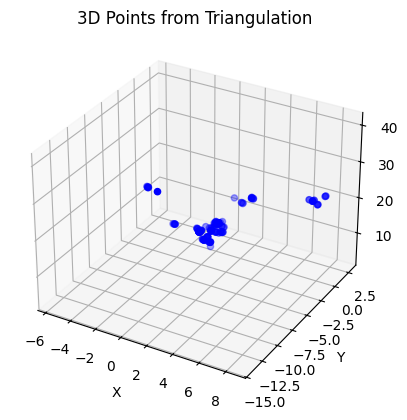

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

def triangulate_points(left_pts, right_pts, K, R, t):
    # Construct projection matrices
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))  # Projection matrix for the left camera
    P2 = K @ np.hstack((R, t))                        # Projection matrix for the right camera

    # Convert points to row order (2xN) for cv2.triangulatePoints
    left_pts_row = left_pts.T
    right_pts_row = right_pts.T

    # Triangulate points
    points_4d_homogeneous = cv2.triangulatePoints(P1, P2, left_pts_row, right_pts_row)

    # Convert from homogeneous coordinates to 3D (Nx3)
    points_3d = points_4d_homogeneous[:3] / points_4d_homogeneous[3]
    points_3d = points_3d.T

    return points_3d

def plot_3d_points(points_3d):
    """
    Plot 3D points using matplotlib.

    Args:
        points_3d (np.ndarray): Triangulated 3D points (Nx3).
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='b', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Points from Triangulation')
    plt.show()

# Assuming left_pts, right_pts, K, R, and t are already defined
points_3d = triangulate_points(left_pts, rght_pts, K, R, t)

# Plot the 3D points
plot_3d_points(points_3d)

<font color='blue'>

# Questions

<font color='blue'>

**Question**: Comment on the epipolar lines. How do they look in comparison to the pure DLT method previously used?

Epipolar lines are the projections of corresponding points in stereo images that define the constraints for point matching. Compared to the pure Direct Linear Transformation (DLT) method, epipolar lines in a calibrated stereo setup ensure that corresponding points lie precisely on these lines, reducing ambiguity in matching. In contrast, DLT does not enforce epipolar geometry constraints explicitly, often leading to higher errors in correspondence estimation (Szeliski, 2022).

<font color='blue'>

**Question**: When we recovered the relative pose of the cameras from the essential matrix, what was the length of the translation vector? Can you explain this length?

The length of the translation vector recovered from the essential matrix is arbitrary due to the inherent scale ambiguity in monocular vision. Typically, it is normalized to 1, meaning that the reconstructed scene is up to an unknown scale factor. This normalization ensures that the relative orientation of points remains correct, but their absolute distances require additional information, such as a known baseline or real-world measurement.

<font color='blue'>

**Question**: Describe the reconstruction of the points? Do they make sense to you? It may be worth drawing the images with the feature correspondence side-by-side the 3D plot so you can compare.

The reconstructed 3D points represent the triangulated positions of matched feature points from stereo images. If the reconstruction is correct, the points should maintain relative spatial consistency with the scene structure. Comparing the 3D plot with the feature correspondences in the image pair helps verify whether the points align logically. Errors in feature matching, calibration, or triangulation could lead to distortions or misplaced points in the 3D reconstruction (Szeliski, 2022).

<font color='blue'>

**Question**: What unit are the 3D points in (trick question)? Explain your answer, and refer to the 3D plot.

The units of the reconstructed 3D points are arbitrary and depend on the scale set by the camera motion. Since the essential matrix recovery process only determines relative translation up to a scale factor, the units are not absolute but proportional. To obtain metric units, an additional scale constraint, such as a known real-world distance in the scene, is required.